# Relocation of AE

This notebook performs the relocation of AEs to improve the accuracy of P and S wave arrival, which is important for the model fitting.

2022.05.13 Kurama Okubo

- 2023.10.21 update for the fb03-087 with event mat file
- 2024.2.4 update for master plot; added the events for all the rupture types. Total number of events is 29.
- 2024.10.30 update for the merged catalog. Total number of events is 44.
- 2025.3.17 update for master plot

In [22]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import pickle
import warnings
from obspy.core.utcdatetime import UTCDateTime    
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator

import itertools
import mpl_interactions.ipyplot as iplt
import scipy.io as sio

%matplotlib widget

%load_ext autoreload
%autoreload 2

import time

from AE_compute_location_func import store_trace

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **Note: Installing Interactive Slider Bar**  

If the plot is not displayed in this notebook and you see the error message:  
`Error displaying widget: model not found`, the issue may be caused by the conda installation.  

To resolve this, try running the following command:  

```sh
pip install --upgrade ipympl ipywidgets jupyterlab_widgets
```

and restart the jupyter lab kernel.

In [23]:
figdir = "../figure/AElocation"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [24]:
# Directory for picked waveforms
datadir = "../data/AElocation"

# Data outputdir
outdir = "../data/AElocation/relocation"
    
# channel table
channel_finame = '../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'

if not os.path.exists(outdir):
    os.makedirs(outdir)
    
csvdir =  "../data/datacsv"
if not os.path.exists(csvdir):
    os.makedirs(csvdir)

In [25]:
# Paramters
fs      = 10e6 #[Hz] Sampling frequency of data
Nsensor = 32 # Number of sensors
st_stats = UTCDateTime(2023, 5, 29) # starttime for the stats of trace: used to synchronize the data. Should be same with picking script.
expr_id= 87 # casename of experiment

ev_twinlen = 0.4e-3 #[s] window length of event
ev_pretrigger = 0.1e-3 #[s] duration of pretrigger

ev_twinlen_k = np.round(ev_twinlen*fs)

## Read channel array

In [26]:
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
Nsensor = len(channel_loc)
# channel_loc

## Read catalog

In [27]:
# Read picked catalog
# Read the csv pick datasheet
fi_catalog="../../Experiments/DetectEvent/data/p06_visual_pick_gougeevents_merged.csv"
columns = ["expr_id", "event_id", "event_loc", "picktime", "event_type", "rupturetype", "gougeevent_id", "doublecheck", "old_gougeevent_id"]
df_catalog = pd.read_csv(fi_catalog, skiprows=5, names=columns)
df_expr = df_catalog[(df_catalog["expr_id"]==f"fb03-{expr_id:03d}")]
df_expr.head()

,expr_id,event_id,event_loc,picktime,event_type,rupturetype,gougeevent_id,doublecheck,old_gougeevent_id
0,fb03-087,2,2.75,41.02500,LFE,2,0,1,0
1,fb03-087,3,1.25,42.46400,LFE,1,1,1,1
2,fb03-087,3,1.25,42.46450,Ordinary,1,2,1,2
3,fb03-087,3,3.25,42.46790,Ordinary,1,3,1,212
4,fb03-087,3,1.75,42.47475,Ordinary,1,4,1,3


# Plot traces

- The timing notations

```
|------------|---|-----------|--------|

1            2   3           4
```

Tstart(mat) init_abs_t=picktime(mat)-pretrig    origin_abs_t    tpick

- 1. Tstart: the absolute start time of event dataset saved in mat file `p03_save_eventdata.m`.
- 2. init_abs_t: the manually detected time of the event with `p06_search_gougeevents.m`. Not the P wave pick.
- 3. origin_abs_t: The origin time of the event, which is obtained from the grid search with the P wave picked times. 
- 4. tpick: The P wave pick time from init_abs_t by `01_AE_locateevent_GUI.py`.


In [28]:
# choose the event
# foreshock_eventset1 = [3, 16, 17, 30, 51, 52, 58, 61, 77, 91, 99, 106] # Ordinary,  x=1750, rupturetype=1
# foreshock_eventset1 = [3, 16, 17, 30, 51, 52, 58, 61, 77, 91, 99, 106, 21, 32, 35, 67, 90, 97, 104, \
#             24, 36, 41, 43, 46, 70, 71, 81 ,82] # Ordinary, x=1750, rupturetype all (1, 2, and 3) # excluded 37 due to low S/N 

foreshock_eventset_merged = [4,   9,  18,  19,  20,  21,  24,  27,  30,  31,  37,  38,  40,
        43,  44,  49,  50,  52,  55,  59,  61,  62,  69,  72,  75,
        76,  77,  81,  85,  88,  89,  95,  99, 100, 102, 109, 110, 111,
       118, 120, 126, 128, 129, 131] # excluded 45 (old id:37) due to low S/N 

# print(len(foreshock_eventset1))

i = 17 # Event id from the list above

pickdir = os.path.join(datadir, f"arrivalpick/{foreshock_eventset_merged[i]:04d}")
# pickdir_list = sorted(glob(os.path.join(datadir, "arrivalpick/*")))
# origintime_prev = 0
# pickdir_list_id = foreshock_eventset1 #[20] # event to be inverted
# pickdir = pickdir_list[pickdir_list_id[6]]

In [29]:
pickdir

'../data/AElocation/arrivalpick/0052'

In [30]:
gougeevent_id = int(os.path.basename(pickdir))
stickslipevent_id = df_expr[df_expr["gougeevent_id"]==gougeevent_id]["event_id"].values[0] # event_id of stick-slip
df_event = pd.DataFrame(columns=["gougeevent_id", "exprID", "origin_time", "X", "Y", "V"])

# relocated dir
eventoutdir = outdir+"/{:04d}".format(gougeevent_id)
if not os.path.exists(eventoutdir):
    os.makedirs(eventoutdir)
    
finame_loc = os.path.join(pickdir, "eventloc__fb03-{:03d}__{:04d}.pickle".format(expr_id, gougeevent_id))
if os.path.exists(finame_loc):
    print(f"start processing event {gougeevent_id:04d}")
    with open(finame_loc, "rb") as fi:
        tpick_loc = pickle.load(fi)
# else:
#     continue #skipping this event because no pick file found.

finame_pick = os.path.join(pickdir, "tpick__fb03-{:03d}__{:04d}.pickle".format(expr_id, gougeevent_id))
if os.path.exists(finame_pick):
    with open(finame_pick, "rb") as fi:
        tpick = pickle.load(fi)

# load relocated pick file
foeventname = os.path.join(eventoutdir, "eventloc__fb03-{:03d}__{:04d}.pickle".format(expr_id, gougeevent_id))
if os.path.exists(foeventname):
    print("relocated pick file found")
    with open(foeventname, "rb") as fi:
        tpick_loc_relocated = pickle.load(fi)
        
# skip if origin time is too close to the previous event
# if np.abs(origintime_prev - tpick_loc["origin_abs_t"]) < 0.1: # less than 0.1 second
#     origintime_prev = tpick_loc["origin_abs_t"]
#     continue

# append to dataframe
df_event =  pd.DataFrame(data={
                             "gougeevent_id":[gougeevent_id],
                             "exprID":[expr_id],
                             "origin_time":[tpick_loc["origin_abs_t"]],
                             "X": [tpick_loc["X"]],
                             "Y": [tpick_loc["Y"]],
                             "V": [tpick_loc["V"]],
                            })
# df_event = pd.concat([df_event, pd.DataFrame(data={
#                                          "gougeevent_id":[gougeevent_id],
#                                          "exprID":[expr_id],
#                                          "origin_time":[tpick_loc["origin_abs_t"]],
#                                          "X": [tpick_loc["X"]],
#                                          "Y": [tpick_loc["Y"]],
#                                          "V": [tpick_loc["V"]],
#                                         })])

# compute tpick from origin time
tpick_rel = {}
for key in tpick:
    tpick_rel[key] = ( tpick_loc["init_abs_t"] + tpick[key]*1e-3 ) - tpick_loc["origin_abs_t"]# tpick is in ms.

# read waveform
data_rootdir = f"/Volumes/Okuboetal2025_masterHDD/4mBIAX_eventdata_master/p03_eventdata_FB03_{expr_id:03d}/" #f"/Volumes/4mGouge_WorkHDD/FB03data/4mBIAX_paper_tmp/p03_eventdata_FB03_{expr_id:03d}/"
fname = f"eventdata_FB03_087_event{stickslipevent_id:02d}"

D = sio.loadmat(data_rootdir+fname)

# read data
read_starttime = tpick_loc["origin_abs_t"] - D["Tstart"] - ev_pretrigger
init_k = int(np.squeeze(read_starttime*fs)) # trim start time from picktime - pretrig
datmat = D['AEdatmat'][init_k:int(init_k+ev_twinlen_k), :]

# read_init_t = tpick_loc["origin_abs_t"] - ev_pretrigger #[s]
# datmat,tmat,Ch_info=SBENCHreader(read_init_t, ev_pretrigger+ev_twinlen, pname, runID, pretrigger=False)

st_obs = store_trace(datmat, fs, st_stats, tpick_loc["origin_abs_t"] - ev_pretrigger)
st_obs.channel_loc = channel_loc

# store metadata
st_obs.pretrigger = ev_pretrigger
st_obs.eventloc = tpick_loc
st_obs.tpick_rel = tpick_rel
st_obs.st_stats = st_stats
st_obs.runID =  f"fb03-{expr_id:03d}"

# foname = os.path.join(outdir, "obs_waveform_event__{}__{:04d}.pickle".format(runID, event_id))
# st_obs.write(foname, format="PICKLE")
# update origintime
origintime_prev = tpick_loc["origin_abs_t"]

start processing event 0052
relocated pick file found


100%|████████████████████████████████████████| 32/32 [00:00<00:00, 40209.03it/s]


In [31]:
tpick_loc_relocated

{'init_abs_t': array([[100.6033]]),
 'origin_abs_t': array([[100.60336415]]),
 'T': 0.06414535097568298,
 'X': 1.7445,
 'Y': 0.005349999999999999,
 'dx_best': 0.0,
 'dy_best': -0.0003999999999999993,
 'V': 6200,
 'Vs': 3600,
 'R': 3.0479006462057714e-07,
 'tpick_rel': {'OL01': 0.25108318269687957,
  'OL02': 0.2156581215795635,
  'OL03': 0.17864779064835354,
  'OL04': 0.13526132572059163,
  'OL05': 0.09522057646108686,
  'OL06': 0.06186989817518786,
  'OL07': 0.019107201068557813,
  'OL08': 0.029864362338365993,
  'OL09': 0.06834102840059697,
  'OL10': 0.10817085193154513,
  'OL11': 0.14666105817820946,
  'OL12': 0.18846026200873114,
  'OL13': 0.22869886414334872,
  'OL14': 0.2689626211656319,
  'OL15': 0.30924170761378167,
  'OL16': 0.34953082395013335,
  'OL17': 0.2358428479314041,
  'OL18': 0.19561091052611923,
  'OL19': 0.155425959006501,
  'OL20': 0.1153371153146059,
  'OL21': 0.07549763324018792,
  'OL22': 0.03672813772050294,
  'OL23': 0.01580634669155435,
  'OL24': 0.04901577410

In [32]:
tpick_loc['X'], tpick_loc['Y'], tpick_loc['V']

(1.7445, 0.005749999999999998, 6200.0)

In [33]:
# tpick_rel
gougeevent_id

52

In [34]:
# compute source distance
source_loc = np.array([df_event.iloc[0].X, df_event.iloc[0].Y, 0]) #[m]
d_dist = {}
for key in tpick_rel.keys():
    sensorloc = np.array(channel_loc[key]) * 1e-3 #{m}
    d_dist[key] = np.linalg.norm(sensorloc - source_loc)
    
key_dist_sorted = [k for k, v in sorted(d_dist.items(), key=lambda item: item[1])] # get key sorted by distance

In [35]:
# trim the event
pt = st_obs.pretrigger
pwinlen = 100e-6 #[s]
starttime_tmp = st_obs[0].stats.starttime + pt
endtime_tmp = st_obs[0].stats.starttime + pt + pwinlen
st_obs_trim = st_obs.copy().trim(starttime_tmp, endtime_tmp, pad=True, fill_value=0, nearest_sample=True)

In [36]:
Ntrace = 6
Ngrid = 201

ot_range = np.linspace(-0.1, 0.1, Ngrid) # range of origin time
cp_range = [6200] # cp_range = np.linspace(5400, 7000, Ngrid) #[m/s]
cs_range = [3600] #np.linspace(3300, 3900, Ngrid) #[m/s]
dx_range = np.linspace(-10e-3, 10e-3, Ngrid)
dy_range = np.linspace(-10e-3, 10e-3, Ngrid)

pick original: x=1.744m z=0.006m vp=6200.0


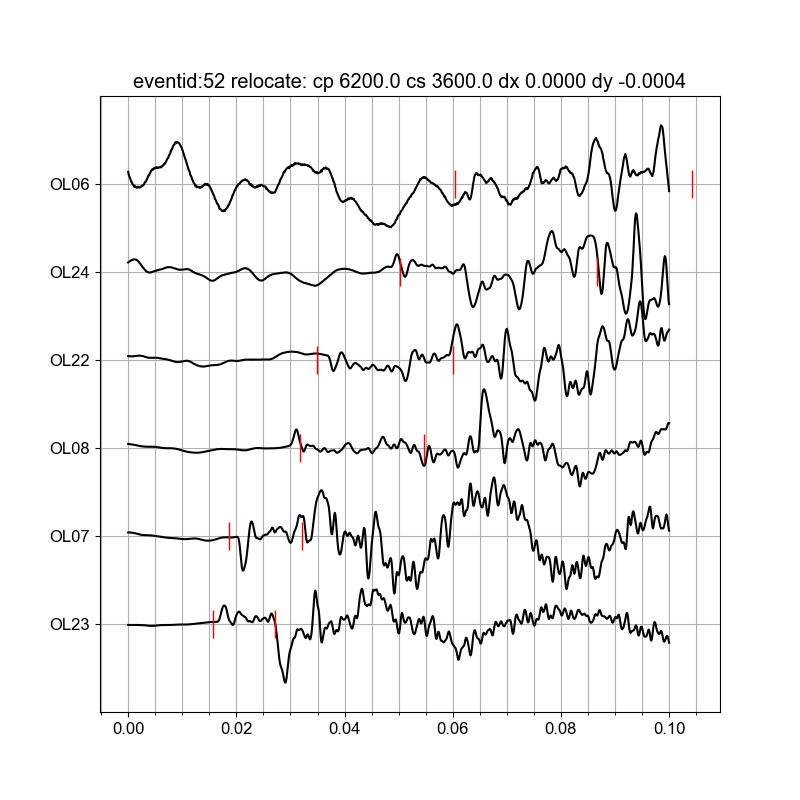

In [37]:
print("pick original: x={:.3f}m z={:.3f}m vp={:.1f}".format(tpick_loc['X'], tpick_loc['Y'], tpick_loc['V']))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# ampnorm = 1e1
y_shift = 0

minor_locator = AutoMinorLocator(4)
ax.xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')
ax.grid(True, which="both")  

d_yshift = {}

sensorids = key_dist_sorted[:Ntrace]

for i, sensorid in enumerate(sensorids):
    tr = st_obs_trim.select(station=sensorid)[0]
    ampnorm = 1.5*np.max(np.abs(tr.data))
    ax.plot(tr.times()*1e3, tr.data/ampnorm + y_shift, "k-")
    d_yshift[sensorid] = y_shift
    y_shift += 1
    
def f_arrival(cp_try, cs_try, dx_try, dy_try):
    # plot synthetic arrival time
    px = []
    py = []
    for sensorid in sensorids:
        # recompute synthetic P and S arrival
        source_loc_new =  source_loc + np.array([dx_try, dy_try, 0])
        sensorloc = np.array(channel_loc[sensorid]) * 1e-3 #{m}
        dist = np.linalg.norm(sensorloc - source_loc_new) #[m]
        tpick_p_syn = dist/cp_try * 1e3
        tpick_s_syn = dist/cs_try * 1e3
        px.append(tpick_p_syn)
        px.append(tpick_s_syn)
        py.append(d_yshift[sensorid])
        py.append(d_yshift[sensorid])
                
    X = np.array([px, py])
    return X.transpose()

# # ax.plot(px, py, "|", ms=20, c="r")
controls = iplt.plot(f_arrival, "|", cp_try=cp_range, cs_try=cs_range, dx_try=dx_range, dy_try=dx_range, ax=ax, 
                     parametric=True, ms=20, c="r", slider_formats={"cp_try": "{:.1f}", "cs_try": "{:.1f}", "dx_try": "{:.4f}", "dy_try": "{:.4f}", })

ax.set_yticks(range(Ntrace));
ax.set_yticklabels(sensorids);
# ax.set_xlim([-0.005, pwinlen*1e3])
ax.set_ylim([-1.0, Ntrace])
if os.path.exists(foeventname):
    titlestr = r"eventid:{} relocate: cp {:4.1f} cs {:4.1f} dx {:4.4f} dy {:4.4f}".format(df_event["gougeevent_id"].values[0], tpick_loc_relocated["V"], tpick_loc_relocated["Vs"], tpick_loc_relocated["dx_best"], tpick_loc_relocated["dy_best"])
    ax.set_title(titlestr)




In [38]:
# use tpick_loc_relocated if file exists; we transfered main and tiny events. 

if os.path.exists(foeventname):
    print(f"{foeventname} pickfile found:")
    # print(tpick_loc_relocated)   
    cp_best = tpick_loc_relocated["V"]
    cs_best = tpick_loc_relocated["Vs"]
    dx_best = tpick_loc_relocated["dx_best"]
    dy_best = tpick_loc_relocated["dy_best"]
else:
    # use the values from control 
    print(f"{foeventname} pickfile not found: set from control.")

    cp_best = controls.params["cp_try"]
    cs_best = controls.params["cs_try"]
    dx_best = controls.params["dx_try"]
    dy_best = controls.params["dy_try"]

print(cp_best, cs_best, dx_best, dy_best)

../data/AElocation/relocation/0052/eventloc__fb03-087__0052.pickle pickfile found:
6200 3600 0.0 -0.0003999999999999993


In [39]:
cp_best, cs_best, dx_best, dy_best

(6200, 3600, 0.0, -0.0003999999999999993)

In [40]:
tpick_loc_new = {}
tpick_rel_new = {}
source_loc_new =  source_loc + np.array([dx_best, dy_best, 0])

for sensorid in tpick_rel.keys():
    # recompute relocated P and S arrival with new sensorloc
    sensorloc = np.array(channel_loc[sensorid]) * 1e-3 #{m}
    dist = np.linalg.norm(sensorloc - source_loc_new) #[m]
    tpick_p_syn = dist/cp_best * 1e3
    tpick_s_syn = dist/cs_best * 1e3
    
    tpick_rel_new[sensorid] = tpick_p_syn
    
    
tpick_loc_new["init_abs_t"] = tpick_loc["init_abs_t"]
tpick_loc_new["origin_abs_t"] = tpick_loc["origin_abs_t"]
tpick_loc_new["T"] = tpick_loc["T"]
tpick_loc_new["X"] = source_loc_new[0]
tpick_loc_new["Y"] = source_loc_new[1]
tpick_loc_new["dx_best"] = dx_best
tpick_loc_new["dy_best"] = dy_best
tpick_loc_new["V"] = cp_best
tpick_loc_new["Vs"] = cs_best
tpick_loc_new["R"] = tpick_loc["R"]
tpick_loc_new["tpick_rel"] = tpick_rel_new

In [41]:
# store meta data

foeventname = os.path.join(eventoutdir, "eventloc__{}__{:04d}.pickle".format(st_obs.runID, gougeevent_id))

## !Remove comment out to update the pick files! ##
# with open(foeventname, 'wb') as fo:
#     pickle.dump(tpick_loc_new, fo, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
source_loc_new

array([1.7445 , 0.00535, 0.     ])

We saved the relocated source information in the eventdir. We will save the waveform in the next step.